In [45]:
import math
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision.transforms import v2
%matplotlib inline
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

In [46]:
transform = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])
test_data = datasets.MNIST(
    root="data", train=False, download=True, transform=transform
)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)


In [47]:
composite_data = torch.load('data/composite_test.pt')
composite_dataset = TensorDataset(composite_data['images'], composite_data['output_seqs'])
composite_dataloader = DataLoader(composite_dataset, batch_size=64, shuffle=False)

In [48]:
images, labels = next(iter(composite_dataloader))

In [49]:
labels.shape

torch.Size([64, 5])

In [50]:
images.shape


torch.Size([64, 1, 56, 56])

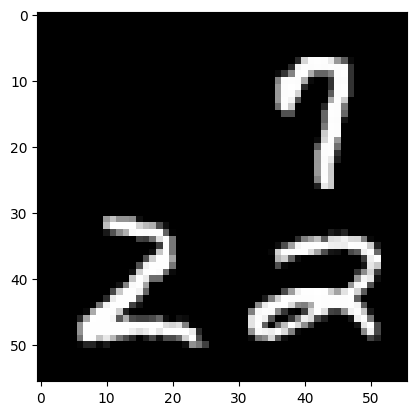

In [51]:
plt.imshow(images[8].reshape(56,56), cmap="gray")
plt.show()

In [52]:
images, labels = next(iter(test_dataloader))

In [53]:
labels

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3])

In [54]:
image = images[0]

In [55]:
c, h, w = image.shape

In [56]:
unfolder = nn.Unfold(kernel_size=14, stride=14)
patches = unfolder(images)

In [57]:
patches.shape

torch.Size([64, 196, 4])

In [58]:
rotated = patches.permute(0, 2, 1)

In [59]:
rotated.shape

torch.Size([64, 4, 196])

In [60]:
linear = nn.Linear(196, 64, bias=False)

In [61]:
result = linear(rotated)

In [62]:
result.shape

torch.Size([64, 4, 64])

In [63]:
rotated[0].shape

torch.Size([4, 196])

In [64]:
import models

In [65]:
loss_fn = nn.CrossEntropyLoss()

In [66]:
patchify = models.Patchify()
encoders = nn.ModuleList([models.Encoder() for _ in range(6)])
linear = nn.Linear(64, 10)
patched = patchify(images)
for encoder in encoders:
    patched = encoder(patched)
result = linear(patched)

In [67]:
result.shape

torch.Size([64, 16, 10])

In [68]:
meaned = result.mean(dim=1)

In [69]:
meaned.shape

torch.Size([64, 10])

In [70]:
labels.shape

torch.Size([64])

In [71]:
loss_fn = nn.CrossEntropyLoss()

In [72]:
loss= loss_fn(meaned, labels)

In [73]:
loss.backward()

In [74]:
# pe work
pe = torch.zeros(128, 64)
position = torch.arange(0, 128, dtype=torch.float).unsqueeze(1)
pe.shape


torch.Size([128, 64])

In [75]:
position.shape

torch.Size([128, 1])

In [76]:
# div_term = torch.exp()
evens = torch.arange(0, 64, 2)
magic = math.log(10_000.0) / 64
div_terms = evens * - magic
div_terms = torch.exp(div_terms)
# div_terms.shape == 32
div_terms

tensor([1.0000e+00, 7.4989e-01, 5.6234e-01, 4.2170e-01, 3.1623e-01, 2.3714e-01,
        1.7783e-01, 1.3335e-01, 1.0000e-01, 7.4989e-02, 5.6234e-02, 4.2170e-02,
        3.1623e-02, 2.3714e-02, 1.7783e-02, 1.3335e-02, 1.0000e-02, 7.4989e-03,
        5.6234e-03, 4.2170e-03, 3.1623e-03, 2.3714e-03, 1.7783e-03, 1.3335e-03,
        1.0000e-03, 7.4989e-04, 5.6234e-04, 4.2170e-04, 3.1623e-04, 2.3714e-04,
        1.7783e-04, 1.3335e-04])

In [77]:
sines = torch.sin(position * div_terms)
cosines = torch.cos(position * div_terms)
sines.shape

torch.Size([128, 32])

In [78]:
tensors = torch.load("data/composite_train.pt")

In [79]:
tensors

{'images': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         ...,
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
   

In [80]:
# insert values to zero'ed positional embedding tensor with shape 128x64
# sines and cosines have shape 128x32
pe[:, 0::2] = sines
pe[:, 1::2] = cosines
pe

tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
          0.0000e+00,  1.0000e+00],
        [ 8.4147e-01,  5.4030e-01,  6.8156e-01,  ...,  1.0000e+00,
          1.3335e-04,  1.0000e+00],
        [ 9.0930e-01, -4.1615e-01,  9.9748e-01,  ...,  1.0000e+00,
          2.6670e-04,  1.0000e+00],
        ...,
        [-6.1604e-01,  7.8771e-01, -4.8905e-01,  ...,  9.9975e-01,
          1.6668e-02,  9.9986e-01],
        [ 3.2999e-01,  9.4398e-01,  2.3663e-01,  ...,  9.9975e-01,
          1.6802e-02,  9.9986e-01],
        [ 9.7263e-01,  2.3236e-01,  8.3536e-01,  ...,  9.9975e-01,
          1.6935e-02,  9.9986e-01]])

In [81]:
pe = pe.unsqueeze(0)
pe.shape

torch.Size([1, 128, 64])

In [82]:
pe

tensor([[[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 8.4147e-01,  5.4030e-01,  6.8156e-01,  ...,  1.0000e+00,
           1.3335e-04,  1.0000e+00],
         [ 9.0930e-01, -4.1615e-01,  9.9748e-01,  ...,  1.0000e+00,
           2.6670e-04,  1.0000e+00],
         ...,
         [-6.1604e-01,  7.8771e-01, -4.8905e-01,  ...,  9.9975e-01,
           1.6668e-02,  9.9986e-01],
         [ 3.2999e-01,  9.4398e-01,  2.3663e-01,  ...,  9.9975e-01,
           1.6802e-02,  9.9986e-01],
         [ 9.7263e-01,  2.3236e-01,  8.3536e-01,  ...,  9.9975e-01,
           1.6935e-02,  9.9986e-01]]])

In [83]:
# 